## 1. Import Modules and Data

In [1]:
from data import mnist_dataloader, cifar10_dataloader
from modules import WGAN
import torch
from torch import nn
import config
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import os
import math
import matplotlib.pyplot as plt
import numpy as np

sample_mnist_dir = os.path.join(config.sample_mnist_dir, "wgan")
sample_cifar10_dir = os.path.join(config.sample_cifar10_dir, "wgan")

os.makedirs(sample_mnist_dir, exist_ok=True)
os.makedirs(sample_cifar10_dir, exist_ok=True)

config.device

Files already downloaded and verified


device(type='cuda', index=0)

## 2. Build Model

In [2]:
model = WGAN(
    z_dim=config.z_dim,
    n_channel=1,  # Output size for MNIST (28x28)
    gen_hidden_dims=[512, 256, 128],
    gen_kernel_size=[4, 3, 4, 4],
    gen_stride=[1, 2, 2, 2],
    gen_padding=[0, 1, 1, 1],
    disc_hidden_dims=[128, 256, 512],
    disc_kernel_size=[4, 4, 3, 4],
    disc_stride=[2, 2, 2, 1],
    disc_padding=[1, 1, 1, 0],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

model2 = WGAN(
    z_dim=config.z_dim,
    n_channel=3,  # Output size for CIFAR10 (3x32x32)
    gen_hidden_dims=[512, 256, 128],
    gen_kernel_size=[4, 4, 4, 4],
    gen_stride=[1, 2, 2, 2],
    gen_padding=[0, 1, 1, 1],
    disc_hidden_dims=[128, 256, 512],
    disc_kernel_size=[4, 4, 4, 4],
    disc_stride=[2, 2, 2, 1],
    disc_padding=[1, 1, 1, 0],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

## 3. Train Model
We train models on MNIST dataset and CIFAR10 dataset.

In [3]:
def train(model, dataloader, sample_dir, epoch):
    optim_G = torch.optim.Adam(
        model.generator.parameters(), lr=config.gen_lr, betas=config.betas
    )
    optim_D = torch.optim.Adam(
        model.discriminator.parameters(),
        lr=config.disc_lr,
        betas=config.betas_gp,
    )
    d_losses = []
    g_losses = []
    step = 0
    for real_images, _ in tqdm(dataloader, desc=f"Training epoch {epoch + 1}"):
        batch_size = real_images.shape[0]
        real_images = real_images.to(config.device)

        # Train Discriminator
        optim_D.zero_grad()
        real_validity = model.discriminate(real_images)

        z = torch.randn(batch_size, config.z_dim, 1, 1, device=config.device)
        fake_images = model.generate(z)
        fake_validity = model.discriminate(fake_images)
        gradient_penalty = model.grad_penalty(real_images, fake_images)
        d_loss = (
            -torch.mean(real_validity)
            + torch.mean(fake_validity)
            + config.lambda_gp * gradient_penalty
        )
        d_loss.backward()
        optim_D.step()
        d_losses.append(d_loss.item())

        step += 1

        if step % config.n_critic == 0:
            # Train Generator
            z = torch.randn(batch_size, config.z_dim, 1, 1, device=config.device)
            fake_images = model.generate(z)
            optim_G.zero_grad()
            fake_validity = model.discriminate(fake_images)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optim_G.step()
            g_losses.append(g_loss.item())

    # Save generated images every sample_interval epoch
    if (epoch + 1) % config.sample_interval == 0:
        model.eval()
        with torch.no_grad():
            fake_images = model.generate(
                torch.randn(
                    config.num_samples, config.z_dim, 1, 1, device=config.device
                )
            )  # Generate num_samples images
            save_image(
                fake_images,
                os.path.join(sample_dir, f"generated_images_epoch_{epoch+1}.png"),
                nrow=int(math.sqrt(config.num_samples)),
                normalize=True,
            )
        model.train()

    return sum(d_losses) / len(d_losses), sum(g_losses) / len(g_losses)

In [4]:
print("Train on MNIST dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(model, mnist_dataloader, sample_mnist_dir, epoch)
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model.save(os.path.join(config.ckpt_mnist_dir, "wgan.pth"))

Train on MNIST dataset...


Training epoch 1: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]


Epoch 1/30 Average Loss D: -19.3499, Average Loss G: 8.6456


Training epoch 2: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


Epoch 2/30 Average Loss D: -16.3437, Average Loss G: 8.3557


Training epoch 3: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]


Epoch 3/30 Average Loss D: -16.3759, Average Loss G: 8.6704


Training epoch 4: 100%|██████████| 469/469 [00:19<00:00, 24.42it/s]


Epoch 4/30 Average Loss D: -16.3524, Average Loss G: 8.7467


Training epoch 5: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]


Epoch 5/30 Average Loss D: -16.3508, Average Loss G: 8.3665


Training epoch 6: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]


Epoch 6/30 Average Loss D: -16.4389, Average Loss G: 8.3947


Training epoch 7: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]


Epoch 7/30 Average Loss D: -15.3579, Average Loss G: 7.5521


Training epoch 8: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]


Epoch 8/30 Average Loss D: -14.6244, Average Loss G: 7.0491


Training epoch 9: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]


Epoch 9/30 Average Loss D: -14.7029, Average Loss G: 7.0397


Training epoch 10: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]


Epoch 10/30 Average Loss D: -14.7673, Average Loss G: 6.9078


Training epoch 11: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


Epoch 11/30 Average Loss D: -14.8069, Average Loss G: 6.8058


Training epoch 12: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]


Epoch 12/30 Average Loss D: -11.1033, Average Loss G: 4.1371


Training epoch 13: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]


Epoch 13/30 Average Loss D: -10.0933, Average Loss G: 3.7630


Training epoch 14: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]


Epoch 14/30 Average Loss D: -10.1622, Average Loss G: 3.7536


Training epoch 15: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]


Epoch 15/30 Average Loss D: -6.0759, Average Loss G: -0.0687


Training epoch 16: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]


Epoch 16/30 Average Loss D: -1.5571, Average Loss G: -4.2744


Training epoch 17: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]


Epoch 17/30 Average Loss D: -1.7671, Average Loss G: -3.5154


Training epoch 18: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Epoch 18/30 Average Loss D: -1.8452, Average Loss G: -3.0848


Training epoch 19: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]


Epoch 19/30 Average Loss D: -1.8339, Average Loss G: -2.9422


Training epoch 20: 100%|██████████| 469/469 [00:19<00:00, 24.42it/s]


Epoch 20/30 Average Loss D: -1.8224, Average Loss G: -2.8479


Training epoch 21: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]


Epoch 21/30 Average Loss D: -1.7937, Average Loss G: -2.8033


Training epoch 22: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]


Epoch 22/30 Average Loss D: -1.7216, Average Loss G: -2.7160


Training epoch 23: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]


Epoch 23/30 Average Loss D: -1.6895, Average Loss G: -2.8716


Training epoch 24: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]


Epoch 24/30 Average Loss D: -1.6546, Average Loss G: -2.8504


Training epoch 25: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]


Epoch 25/30 Average Loss D: -1.6073, Average Loss G: -2.6603


Training epoch 26: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]


Epoch 26/30 Average Loss D: -1.5720, Average Loss G: -2.7070


Training epoch 27: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]


Epoch 27/30 Average Loss D: -1.5476, Average Loss G: -2.6987


Training epoch 28: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Epoch 28/30 Average Loss D: -1.5231, Average Loss G: -2.6846


Training epoch 29: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]


Epoch 29/30 Average Loss D: -1.4726, Average Loss G: -2.6751


Training epoch 30: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]


Epoch 30/30 Average Loss D: -1.4756, Average Loss G: -2.4533


In [4]:
print("Train on CIFAR10 dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(model2, cifar10_dataloader, sample_cifar10_dir, epoch)
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model2.save(os.path.join(config.ckpt_cifar10_dir, "wgan.pth"))

Train on CIFAR10 dataset...


Training epoch 1: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s]


Epoch 1/30 Average Loss D: -26.1434, Average Loss G: 23.7860


Training epoch 2: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]


Epoch 2/30 Average Loss D: -11.0168, Average Loss G: 9.8148


Training epoch 3: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]


Epoch 3/30 Average Loss D: -7.1110, Average Loss G: 5.4978


Training epoch 4: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]


Epoch 4/30 Average Loss D: -4.6277, Average Loss G: 2.3168


Training epoch 5: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Epoch 5/30 Average Loss D: -4.4813, Average Loss G: 2.0350


Training epoch 6: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]


Epoch 6/30 Average Loss D: -4.3069, Average Loss G: 2.5218


Training epoch 7: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]


Epoch 7/30 Average Loss D: -4.0908, Average Loss G: 2.3926


Training epoch 8: 100%|██████████| 391/391 [00:21<00:00, 17.84it/s]


Epoch 8/30 Average Loss D: -3.8637, Average Loss G: 2.0937


Training epoch 9: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]


Epoch 9/30 Average Loss D: -3.6078, Average Loss G: 1.9925


Training epoch 10: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]


Epoch 10/30 Average Loss D: -3.5768, Average Loss G: 1.8591


Training epoch 11: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]


Epoch 11/30 Average Loss D: -3.5034, Average Loss G: 1.8226


Training epoch 12: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s]


Epoch 12/30 Average Loss D: -3.3763, Average Loss G: 1.6910


Training epoch 13: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]


Epoch 13/30 Average Loss D: -3.2910, Average Loss G: 1.6462


Training epoch 14: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]


Epoch 14/30 Average Loss D: -3.1981, Average Loss G: 1.5359


Training epoch 15: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]


Epoch 15/30 Average Loss D: -3.1463, Average Loss G: 1.4786


Training epoch 16: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]


Epoch 16/30 Average Loss D: -3.0883, Average Loss G: 1.4056


Training epoch 17: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]


Epoch 17/30 Average Loss D: -3.0703, Average Loss G: 1.4798


Training epoch 18: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]


Epoch 18/30 Average Loss D: -2.9988, Average Loss G: 1.2443


Training epoch 19: 100%|██████████| 391/391 [00:21<00:00, 17.77it/s]


Epoch 19/30 Average Loss D: -2.9552, Average Loss G: 1.2896


Training epoch 20: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Epoch 20/30 Average Loss D: -2.9413, Average Loss G: 1.4311


Training epoch 21: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]


Epoch 21/30 Average Loss D: -2.9076, Average Loss G: 1.2549


Training epoch 22: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]


Epoch 22/30 Average Loss D: -2.8983, Average Loss G: 1.1714


Training epoch 23: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]


Epoch 23/30 Average Loss D: -2.8319, Average Loss G: 1.1989


Training epoch 24: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]


Epoch 24/30 Average Loss D: -2.8064, Average Loss G: 1.3125


Training epoch 25: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s]


Epoch 25/30 Average Loss D: -2.7630, Average Loss G: 1.1784


Training epoch 26: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]


Epoch 26/30 Average Loss D: -2.7059, Average Loss G: 1.0923


Training epoch 27: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]


Epoch 27/30 Average Loss D: -2.7069, Average Loss G: 1.1727


Training epoch 28: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]


Epoch 28/30 Average Loss D: -2.6380, Average Loss G: 1.0185


Training epoch 29: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]


Epoch 29/30 Average Loss D: -2.6253, Average Loss G: 1.0826


Training epoch 30: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]

Epoch 30/30 Average Loss D: -2.5709, Average Loss G: 1.1565


## 4. Sample
Let's compare the differences between real images and fake images. 

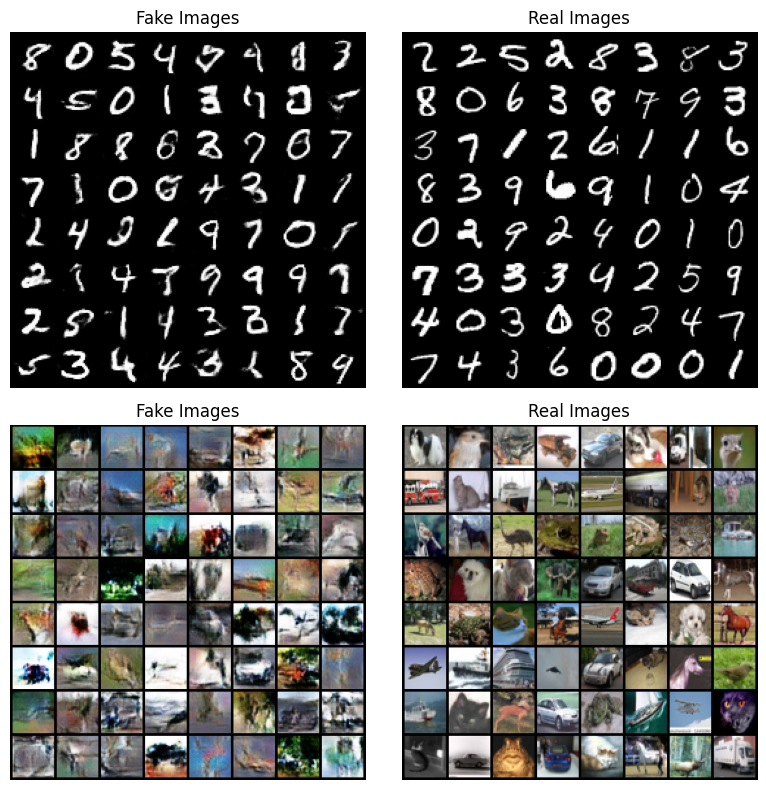

In [6]:
plt.figure(figsize=(8, 8))


def sample_and_compare(model, dataloader, row):
    model.eval()
    real_batch = next(iter(dataloader))

    fake_images = model.generate(torch.randn(64, config.z_dim, 1, 1, device=config.device)).cpu()

    plt.subplot(2, 2, row * 2 - 1)
    plt.imshow(make_grid(fake_images, nrow=8, normalize=True).permute(1, 2, 0))
    plt.axis("off")
    plt.title("Fake Images")

    plt.subplot(2, 2, row * 2)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(
        make_grid(real_batch[0].cpu()[:64], nrow=8, normalize=True).permute(
            1, 2, 0
        )
    )

sample_and_compare(model, mnist_dataloader, 1)
sample_and_compare(model2, cifar10_dataloader, 2)
plt.tight_layout()
plt.show()